In [34]:
%matplotlib inline

In [35]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import math
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.autograd as autograd
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 为再现性设置随机seem
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 如果你想要新的结果就是要这段代码

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [36]:
# 数据集根目录
dataroot = "D:/azhenghuo/important/machine_learning/pytorch DCGAN/only monet"

# 数据加载器并发数
workers = 1

# 训练批的大小
batch_size = 128

# 训练图片的大小. 所有图片都会转成改大小的图片
image_size = 256

# 训练图片的通道数。彩色图片是RGB三个通道
nc = 3

# 噪声向量大小（生成器的输入大小）
nz = 100

# 生成器的特征图大小
ngf = 64

# 判别器的特征图大小
ndf = 64

# 数据集的训练次数
num_epochs = 5

# 学习率
lr = 0.0002

# Adam优化器的beta1参数
beta1 = 0.5

# Loss weight for gradient penalty
lambda_gp = 10

#number of training steps for discriminator per iter
n_critic=5

# 所使用的gpu数量。0表示使用cpu
ngpu = 0

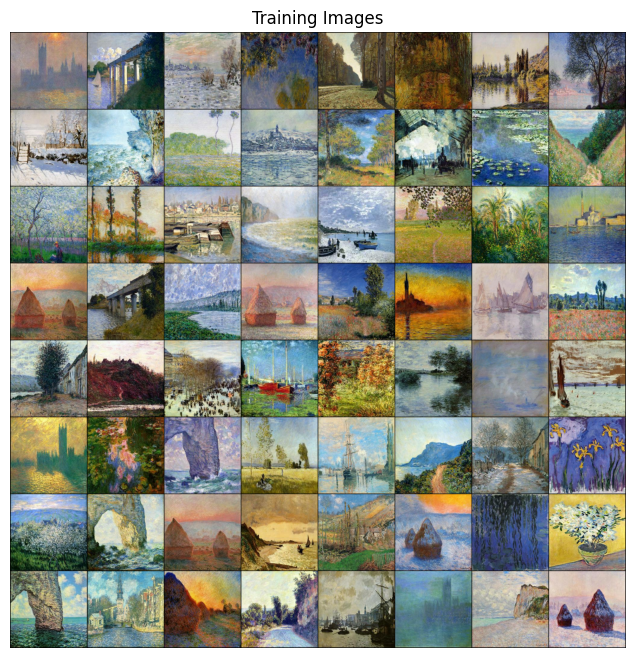

In [37]:
# 我们可以按照设置的方式使用图像文件夹数据集。
# 创建数据集
dataset = dset.ImageFolder(root=dataroot,
                   transform=transforms.Compose([
                       transforms.Resize(image_size),
                       transforms.CenterCrop(image_size),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ]))
# 创建加载器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# 选择我们运行在上面的设备
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 绘制部分我们的输入图像
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(
vutils.make_grid(real_batch[0].to(device)[:64],
                 padding=2, 
normalize=True).cpu(), 
(1,2,0)))

In [38]:
# 自定义的权重初始化函数，用于初始化netG和netD网络
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [39]:
# 生成器代码
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入是Z，输入到卷积层
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ndf) x 64 x 64
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ndf) x 128 x 128
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

In [40]:
# 实例化一个生成器
netG = Generator(ngpu).to(device)

# 使用多个gpu处理
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 使用自定义的权重初始化函数
netG.apply(weights_init)

# 打印模型
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view((-1,1))

In [42]:
# 创建判别器
netD = Discriminator(ngpu).to(device)

# 使用多个gpu处理
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 应用weights_init函数随机初始化所有权重，mean= 0，stdev = 0.2
netD.apply(weights_init)

# 打印模型
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, moment

In [43]:
# 初始化BCELoss函数
criterion = nn.BCELoss()

# 创建一批固定的噪声数据，我们将用它来可视化生成器的学习进程
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 定义训练期间真假图像的标签值
real_label = 1
fake_label = 0

# 为 G 和 D 创建 Adam 优化器
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [46]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
def compute_gradient_penalty_gp(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# DCGAN的训练过程

# 记录训练的过程
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 遍历数据集
for epoch in range(num_epochs):
    # 遍历真实数据中的每一个数据批
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) 更新判别器: 最大化 log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## 使用真实数据构建训练批
        netD.zero_grad()
        # 格式化训练批
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # 产生正态分布的噪声
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # 使用生成器产生假数据
        fake = netG(noise)
        # 前向传播真实数据的训练批到
        real_output = netD(real_cpu).view(-1)
        fake_output = netD(fake).view(-1)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty_gp(netD, real_cpu.data, fake.data)
        # 计算真实数据的损失
        errD = -torch.mean(real_output) + torch.mean(fake_output) + lambda_gp * gradient_penalty
        # 反向传播计算梯度
        errD.backward()
        D_x = fake_output.mean().item()
        # 更新判别器
        optimizerD.step()


        ############################
        # (2) 更新生成器: 最大化 log(D(G(z)))
        ###########################
        if i % n_critic == 0:
            netG.zero_grad()
            fake_imgs = netG(noise)
            fake_out = netD(fake_imgs).view(-1)
            label.fill_(real_label)  # 假数据在生成器看来是真数据
        # 因为判别器在(1)中更新了，所以我们重新进行一次前向传播
        # 计算损失
            errG = -torch.mean(fake_out)
        # 计算G的梯度
            errG.backward()
            D_G_z2 = fake_out.mean().item()
        # 更新生成器
            optimizerG.step()


        # 输出训练状态
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\t'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x))

        # 保存训练时的损失，用于后续打印图形
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # 记录生成器将fixed_noise映射成了什么样的图片
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/3]	Loss_D: 254.0296	Loss_G: -2.8799	D(x): 3.2849	
[1/5][0/3]	Loss_D: 8.4495	Loss_G: -3.4001	D(x): 4.1922	
[2/5][0/3]	Loss_D: 3.3425	Loss_G: -2.5285	D(x): 3.7252	
[3/5][0/3]	Loss_D: 1.2334	Loss_G: -0.7786	D(x): 2.2793	
[4/5][0/3]	Loss_D: -1.2731	Loss_G: 1.3689	D(x): 0.3631	


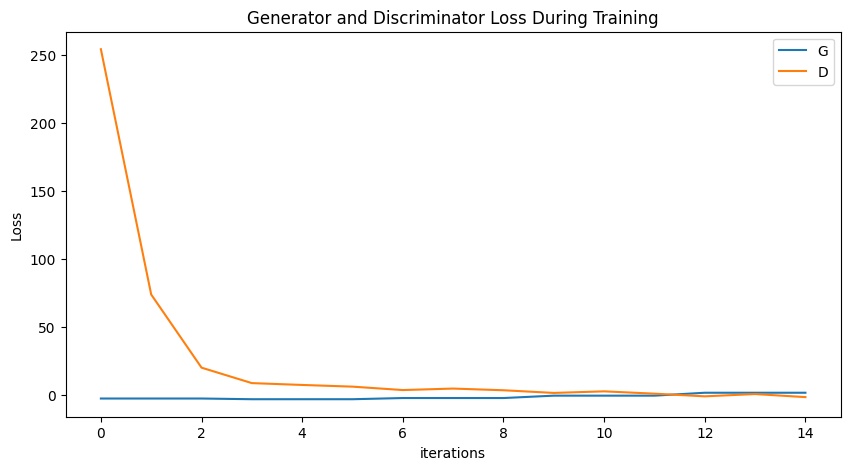

In [47]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

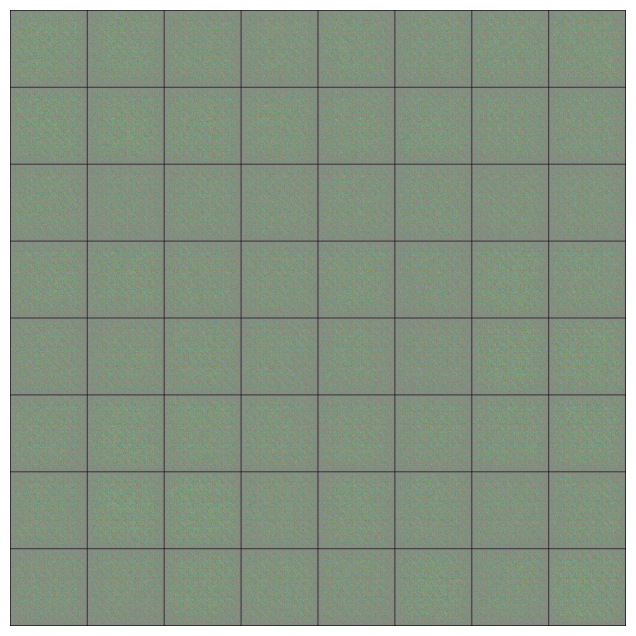

In [48]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

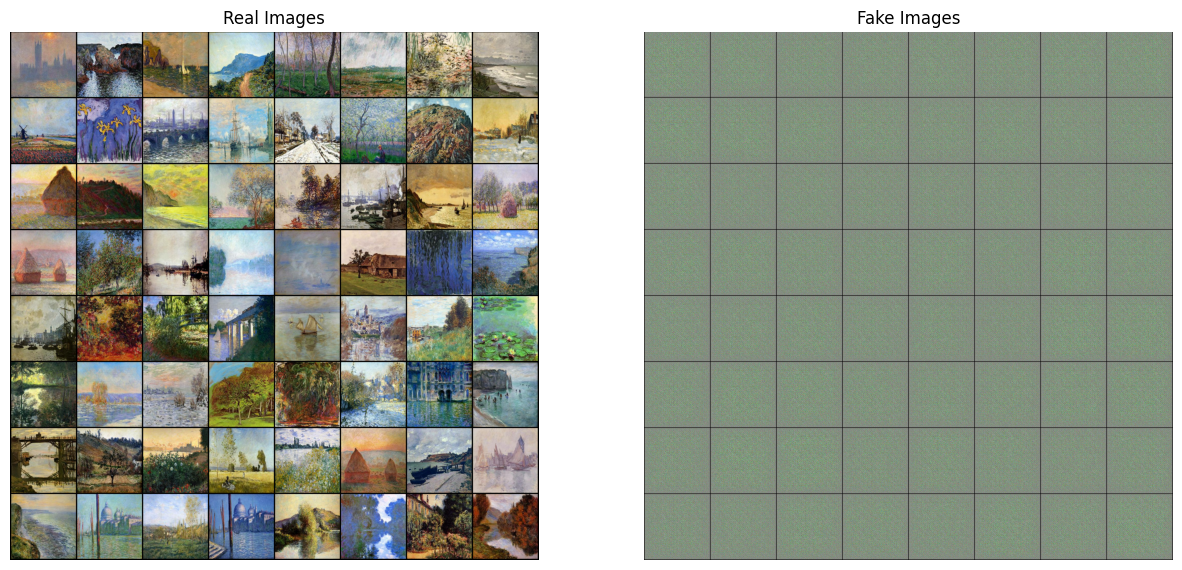

In [49]:
real_batch = next(iter(dataloader))

# 打印真实图片
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 打印假图片
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()